XGBoost Accuracy: 0.9977 
───────────────────────────────

Classification Report:
              precision    recall  f1-score   support

          P1       0.99      0.97      0.98      1116
          P2       1.00      1.00      1.00     16765
          P3       0.97      0.99      0.98      1454
          P4       1.00      1.00      1.00      1200

    accuracy                           1.00     20535
   macro avg       0.99      0.99      0.99     20535
weighted avg       1.00      1.00      1.00     20535



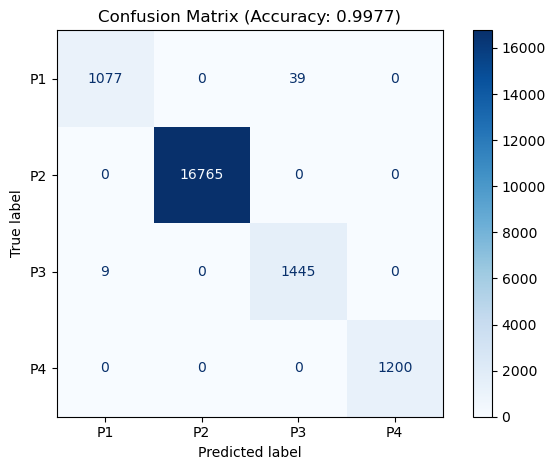

,Approved_Flag,Predicted,Actual_RiskLevel,Predicted_RiskLevel,Correct
0,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
1,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
2,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
3,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
4,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
5,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
6,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
7,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
8,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
9,P3,P3,High Risk - Likely Denied,High Risk - Likely Denied,True



Predictions saved to 'Artifacts/Predictions/prediction_results_xgboost.csv'


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# Load the training and test data
train_data = pd.read_csv("../Data/train_data.csv")
test_data = pd.read_csv("../Data/test_data.csv")

# Define which column we’re trying to predict
target_column = "Approved_Flag"

# Drop any columns that might leak the answer or aren't useful for learning
leakage_columns = [
    target_column,
    "CreditRisk",
    "LoanStatus",
    "IsDefault",
    "RiskLevel",
    "CustomerID",
    "ID",
    "ApplicationID"
]

# Only drop columns that are actually present in the dataset
drop_cols = [col for col in leakage_columns if col in train_data.columns]

# Separate features from target — we keep raw copies for encoding next
X_train_raw = train_data.drop(columns=drop_cols)
X_test_raw = test_data.drop(columns=drop_cols)

# Combine train and test sets to apply consistent one-hot encoding across both
combined = pd.concat([X_train_raw, X_test_raw], axis=0)
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split the combined encoded data back into training and testing sets
X_train = combined_encoded.iloc[:len(X_train_raw), :]
X_test = combined_encoded.iloc[len(X_train_raw):, :]

# Convert string labels into numbers using LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_data[target_column])
y_test = le.transform(test_data[target_column])

# Set up and train the XGBoost model
model = XGBClassifier(n_estimators=500, eval_metric='mlogloss', random_state=52)
model.fit(X_train, y_train)

# Predict on the test set and decode labels back to original values
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)

# Create a DataFrame to compare predictions to actual values
comparison_df = test_data.copy()
comparison_df["Predicted"] = y_pred_labels
comparison_df["Correct"] = comparison_df[target_column] == comparison_df["Predicted"]

# Evaluate how well the model performed
label_names = le.classes_.tolist()
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", round(accuracy, 4), "\n───────────────────────────────")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

# Display confusion matrix to visualize performance by category
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

# Save the trained model to disk for later use
os.makedirs("../Artifacts/PLK", exist_ok=True)
with open("../Artifacts/PLK/xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Add readable risk labels based on prediction category
def flag_to_risk(flag):
    if flag == "P1":
        return "Low Risk - Likely Approved"
    elif flag == "P2":
        return "Medium Risk - Review Needed"
    elif flag == "P3":
        return "High Risk - Likely Denied"
    elif flag == "P4":
        return "Critical Risk - Must Deny"
    else:
        return "Unknown"

comparison_df["Predicted_RiskLevel"] = comparison_df["Predicted"].apply(flag_to_risk)
comparison_df["Actual_RiskLevel"] = comparison_df[target_column].apply(flag_to_risk)

# Save the final comparison with risk levels to a CSV
os.makedirs("../Artifacts/Predictions", exist_ok=True)
comparison_df.to_csv("../Artifacts/Predictions/prediction_results_xgboost.csv", index=False)

# Display a styled preview of the predictions incorrect ones are highlighted
def highlight_incorrect(row):
    return ['background-color: red; color: white' if not row['Correct'] else '' for _ in row]

preview_cols = [target_column, "Predicted", "Actual_RiskLevel", "Predicted_RiskLevel", "Correct"]
random_sample = comparison_df[preview_cols].sample(n=20, random_state=42).reset_index(drop=True)
display(HTML(random_sample.style.apply(highlight_incorrect, axis=1).to_html()))

print("\nPredictions saved to 'Artifacts/Predictions/prediction_results_xgboost.csv'")
